In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pickle
import pymc3

import calibr8
import cutisplit
import pyrff
import retl
import robotools
import scipy

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

pymc 4.0
calibr8 6.0.3


C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_5.0.0\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


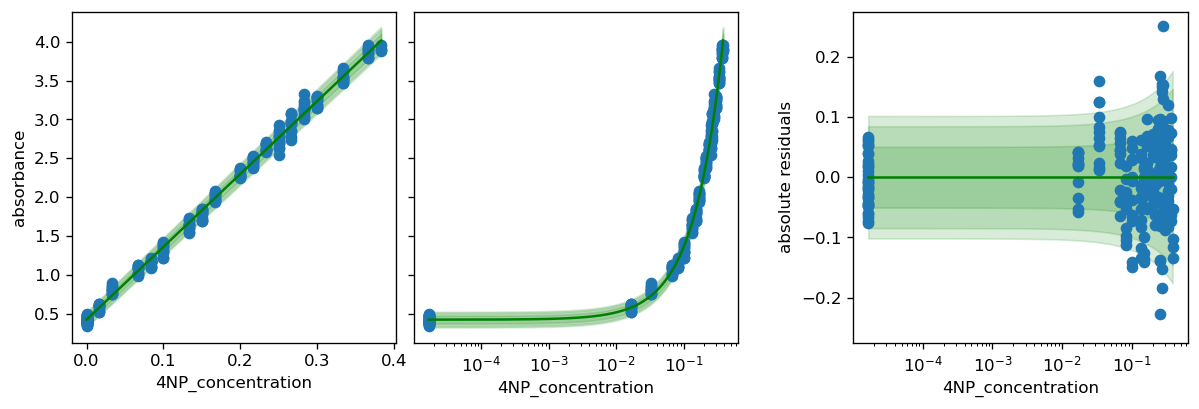

In [8]:
RUN_ID = "BZP1XQ"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol)


df_inputs, df_kinetics = run_analysis.read_rounds(["BZP1XQ", "BWNZ99"])

## Creating the Model

In [10]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

strain              (24,)	AbnA, AmyE, AprE, …, YwmC
culture_id          (48,)	BWNZ99_A02, BWNZ99_A04, BWNZ99_A05, …, BZP1XQ_F07
kinetic_id          (192,)	BWNZ99_1_B01, BWNZ99_1_B02, BWNZ99_1_B03, …, BZP1XQ_2_G12
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

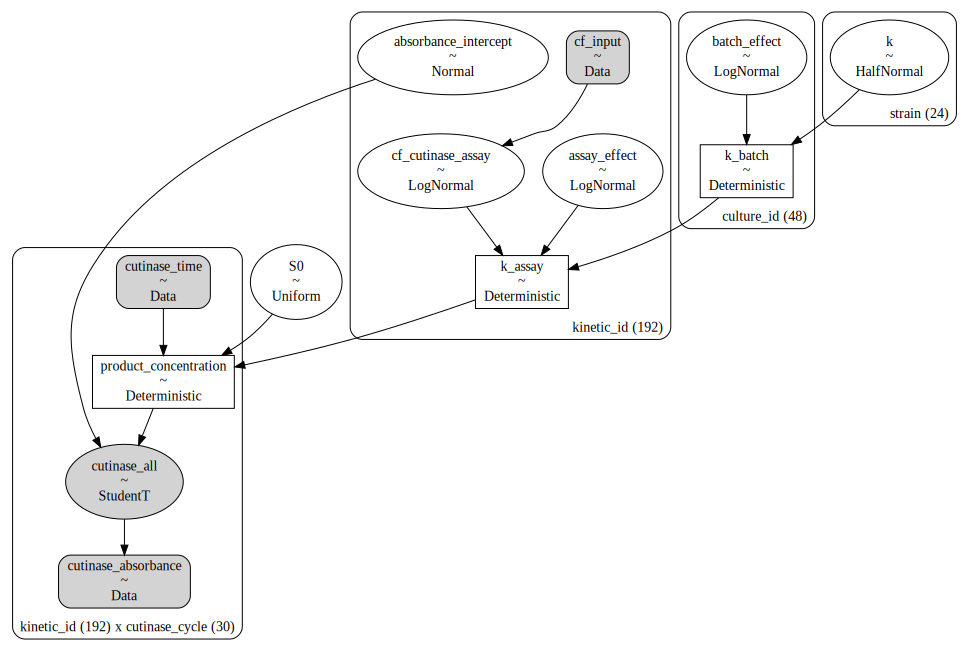

In [11]:
pymc3.model_to_graphviz(model.pmodel)

In [12]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cf_cutinase_assay, k, batch_effect, assay_effect, S0, absorbance_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 480 seconds.


0, dim: kinetic_id, 192 =? 192
1, dim: cutinase_cycle, 30 =? 30


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [13]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_hierarchical.nc")

'BZP1XQ_Results\\BZP1XQ_result_hierarchical.nc'

Execute the next cell in case you want to reload saved data

In [27]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result_hierarchical_non_centered.nc")

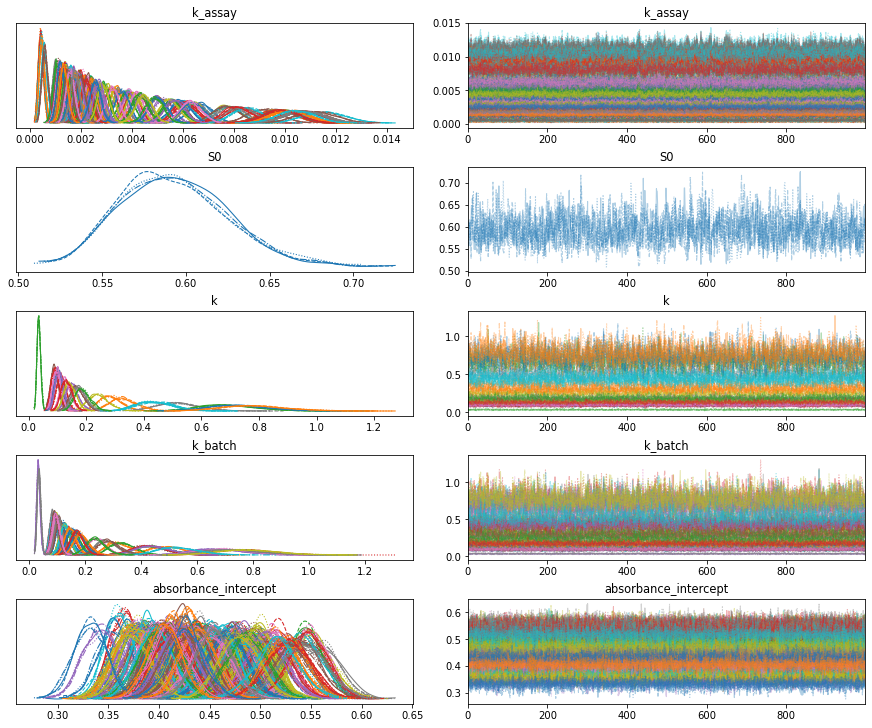

In [14]:
arviz.plot_trace(idata, var_names=[
    "k_assay", "S0", "k", "k_batch", "absorbance_intercept"
]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_5.0.0\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (144) is smaller than the number of resulting pair plots with these variables, generating only a 16x16 grid
  warnings.warn(


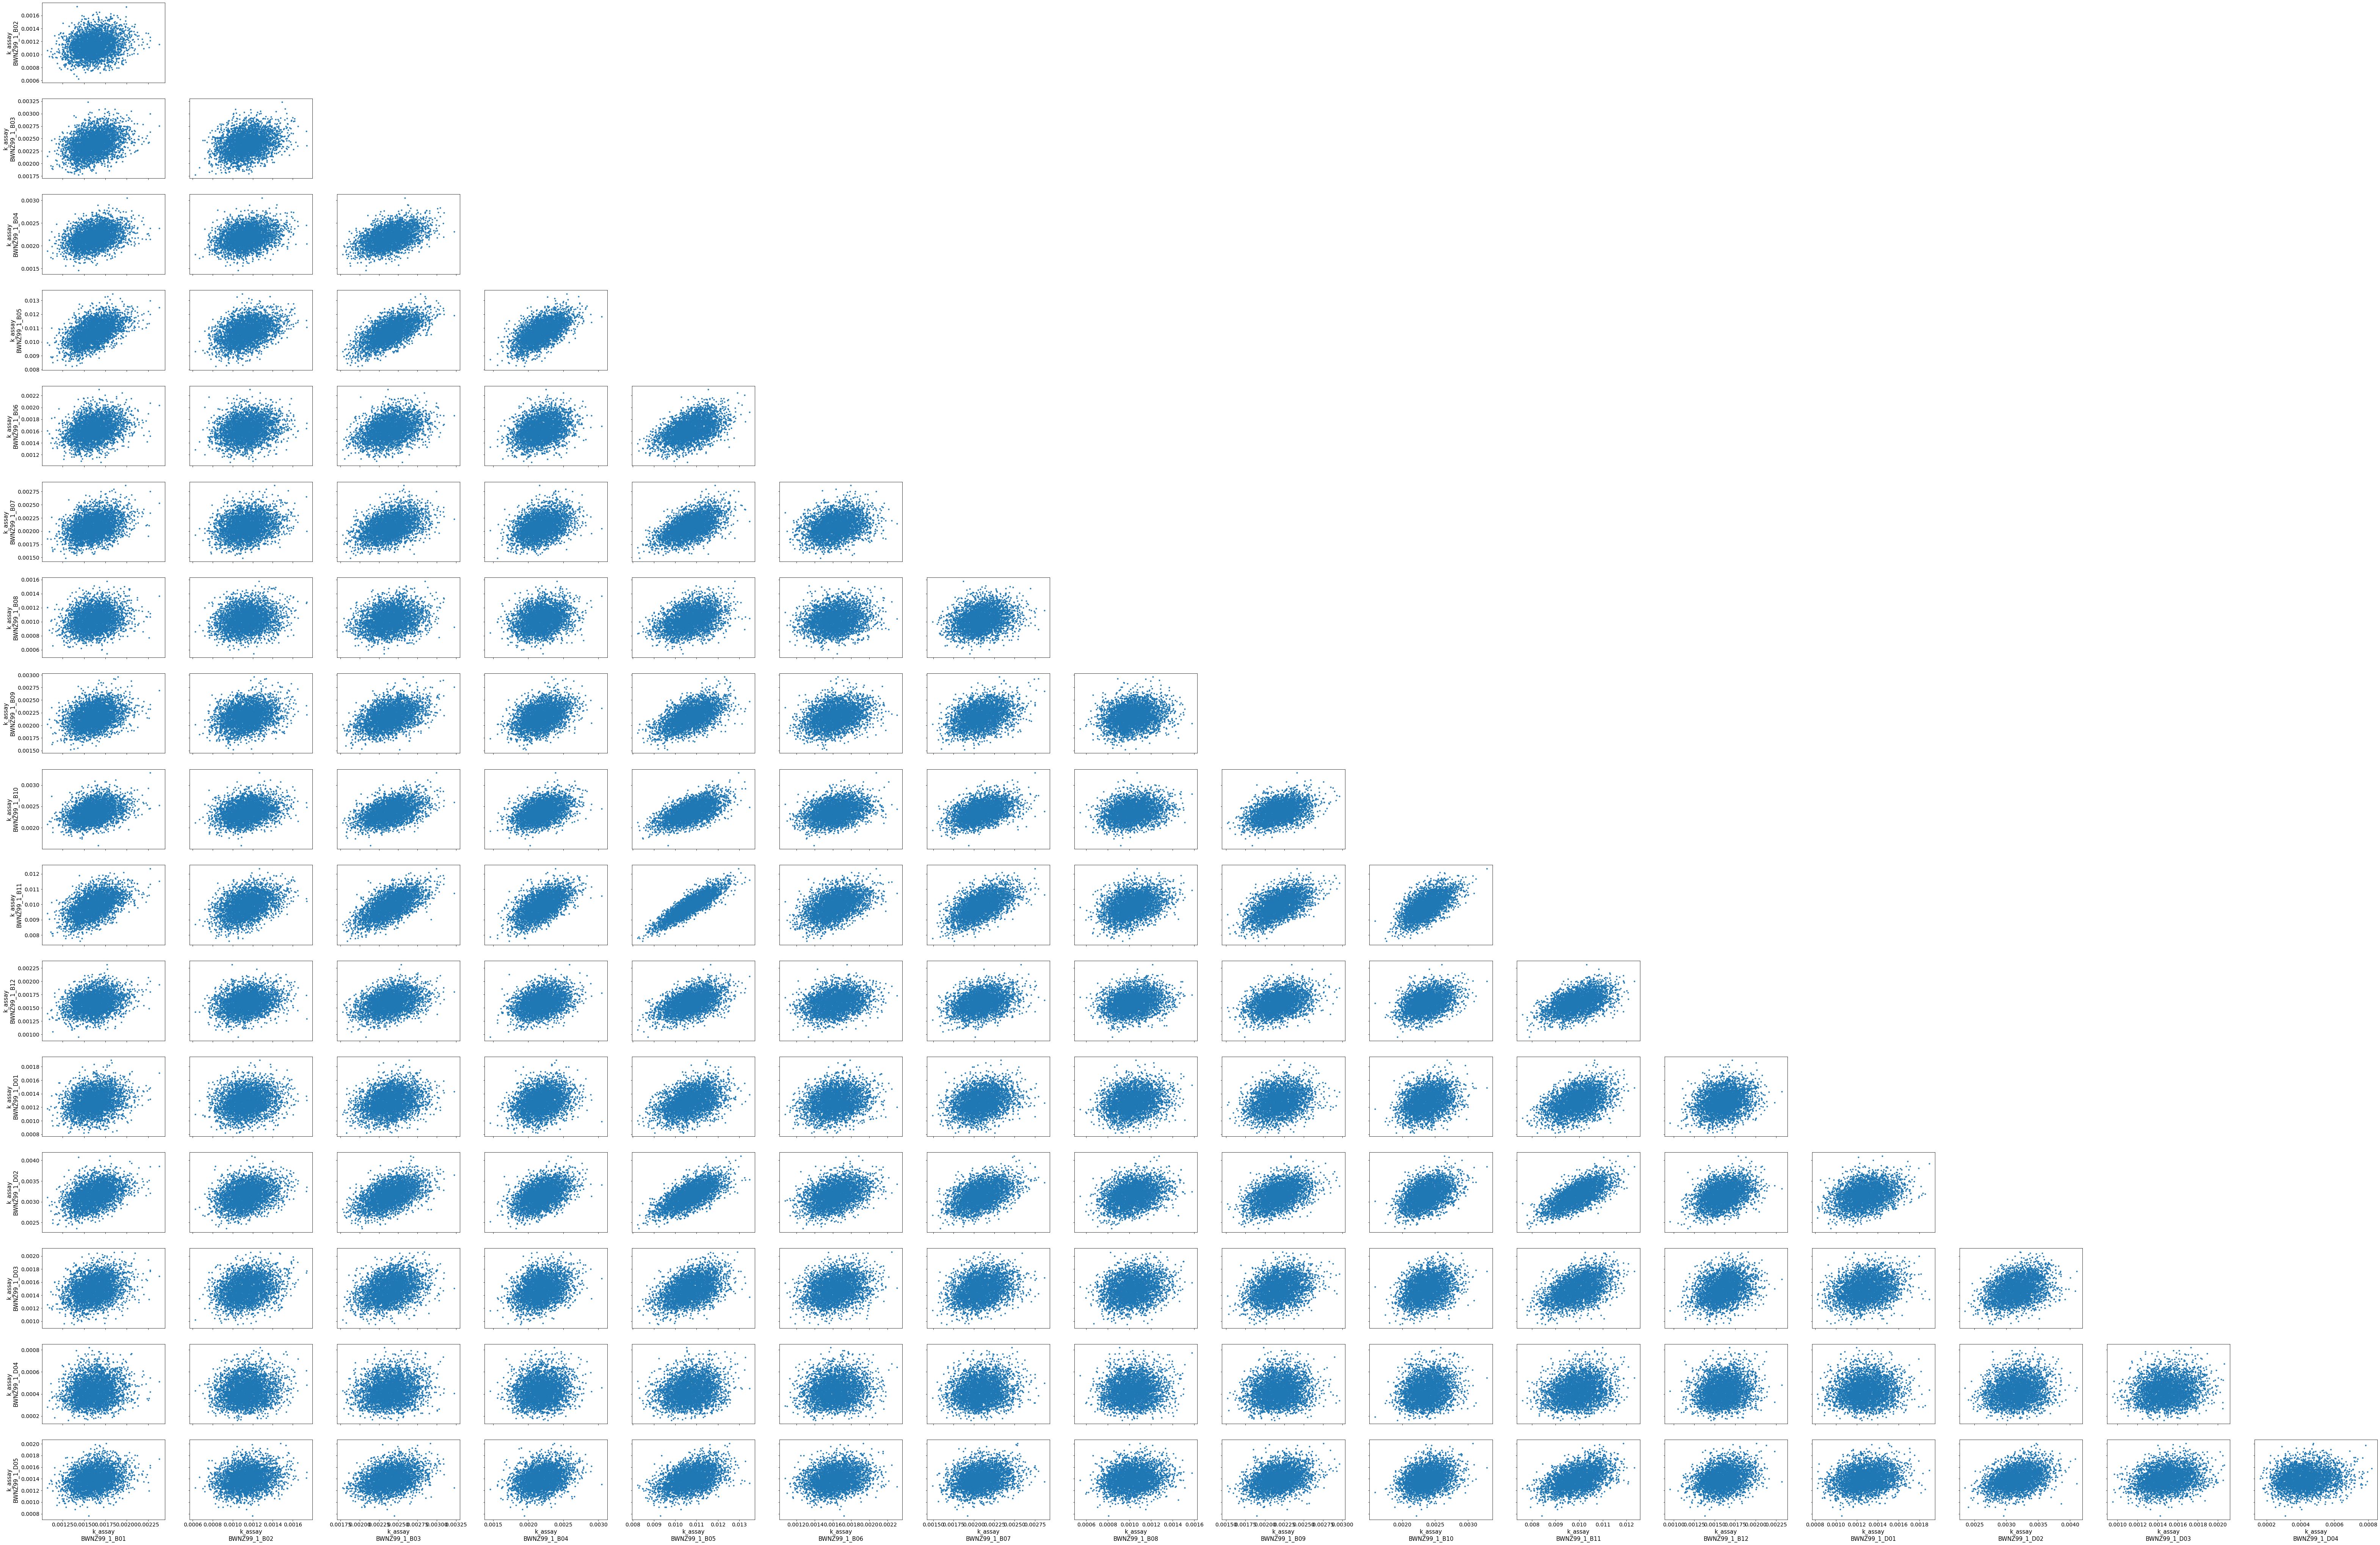

In [15]:
arviz.rcParams['plot.max_subplots'] = 144
arviz.plot_pair(idata, var_names=[
    "k_assay", 
    "k", "k_batch", "S0", 
    "absorbance_intercept"
]);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

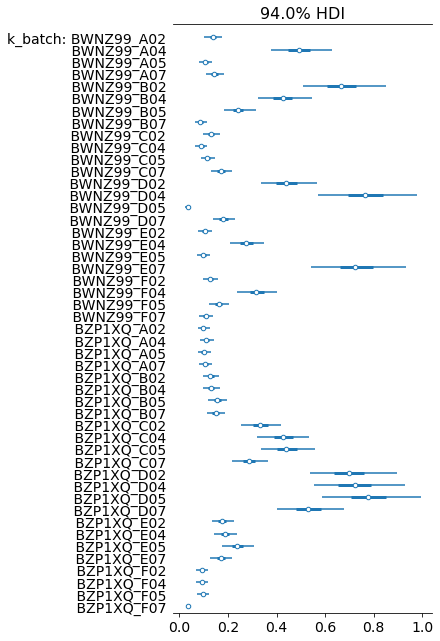

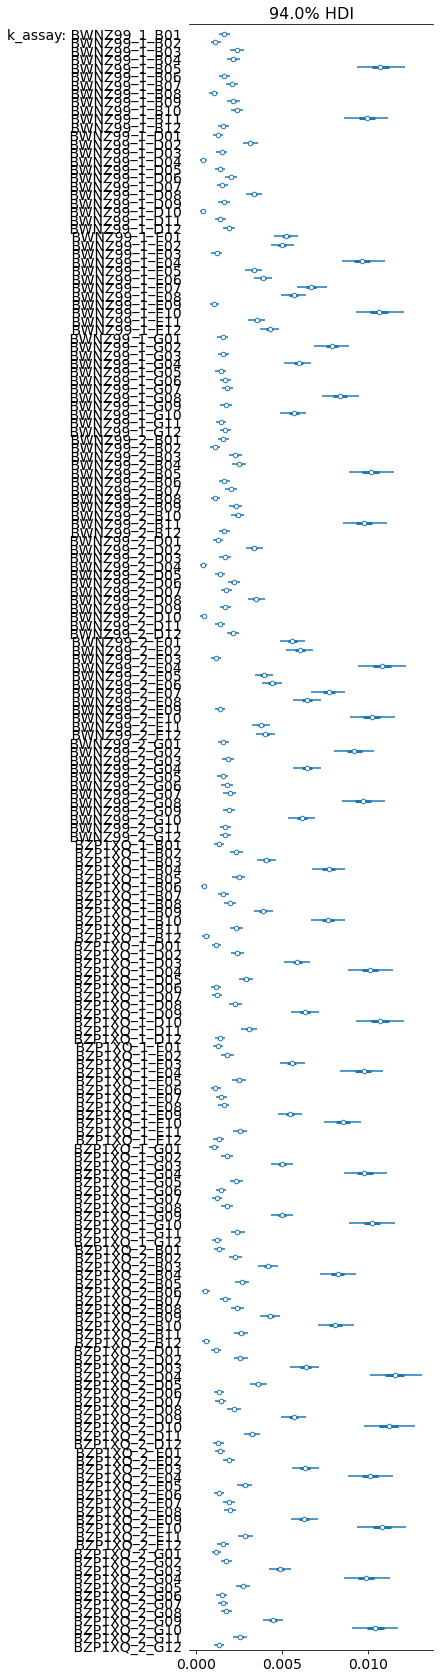

In [16]:
arviz.plot_forest(idata, var_names=["k_batch"], combined=True)
arviz.plot_forest(idata, var_names=["k_assay"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

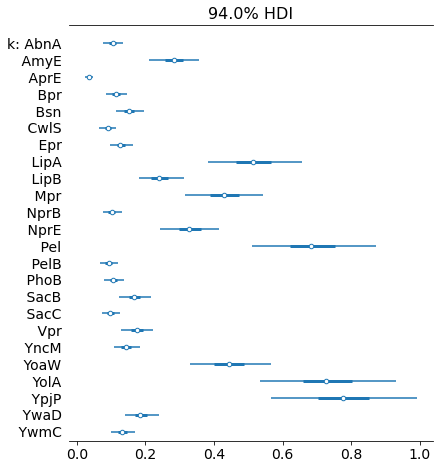

In [17]:
arviz.plot_forest(idata, var_names=["k"], combined=True)

In [18]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (kinetic_id: 192, sample: 4000, strain: 24, culture_id: 48, cutinase_cycle: 30)
Coordinates:
  * kinetic_id             (kinetic_id) <U12 'BWNZ99_1_B01' ... 'BZP1XQ_2_G12'
  * strain                 (strain) <U4 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * culture_id             (culture_id) <U10 'BWNZ99_A02' ... 'BZP1XQ_F07'
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (kinetic_id, sample) float64 1.059 0.961 ... 0.8959
    k                      (strain, sample) float64 0.1331 0.1199 ... 0.133
    batch_effect           (culture_id, sample) float64 0.8346 0.8486 ... 1.113
    assay_effect           (kinetic_id, sample) float64 1.04 1.008 ... 1.063
    S0                     (sample) float64 0.5829 0.5941 ... 0.6001 0.5627
    absorbance_intercept   (kinetic_id, sample) float64 0.3993 0.4095 ... 0.3963
    k_batch                (culture_id, sample) float64 0.1526 ... 0.05027
    k_assay                (kinetic_id, sample) float64 0.001659 ... 0.001305
    product_concentration  (kinetic_id, cutinase_cycle, sample) float64 0.0 ....
Attributes:
    created_at:                 2021-09-24T10:54:19.318388
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  4.0
    sampling_time:              480.3720054626465
    tuning_steps:               1000

In [58]:
strains = numpy.unique(df_inputs.strain.values)
numpy.random.seed(1)
selected_strains = pyrff.sample_batch(
    posterior.k.values,
    ids=strains,
    batch_size=12,
    correlated=True
)
numpy.unique(selected_strains, return_counts=True)

(array(['Pel', 'YolA', 'YpjP'], dtype='<U4'), array([3, 1, 8], dtype=int64))

In [69]:
test = list(selected_strains)
test

['YpjP',
 'Pel',
 'Pel',
 'YpjP',
 'YpjP',
 'Pel',
 'YolA',
 'YpjP',
 'YpjP',
 'YpjP',
 'YpjP',
 'YpjP']

In [70]:
numpy.random.shuffle(test)

In [71]:
test

['Pel',
 'YpjP',
 'YpjP',
 'YpjP',
 'YpjP',
 'YpjP',
 'Pel',
 'Pel',
 'YolA',
 'YpjP',
 'YpjP',
 'YpjP']

In [45]:
probs = pyrff.sampling_probabilities(
    posterior.k.values,
    correlated=True
)

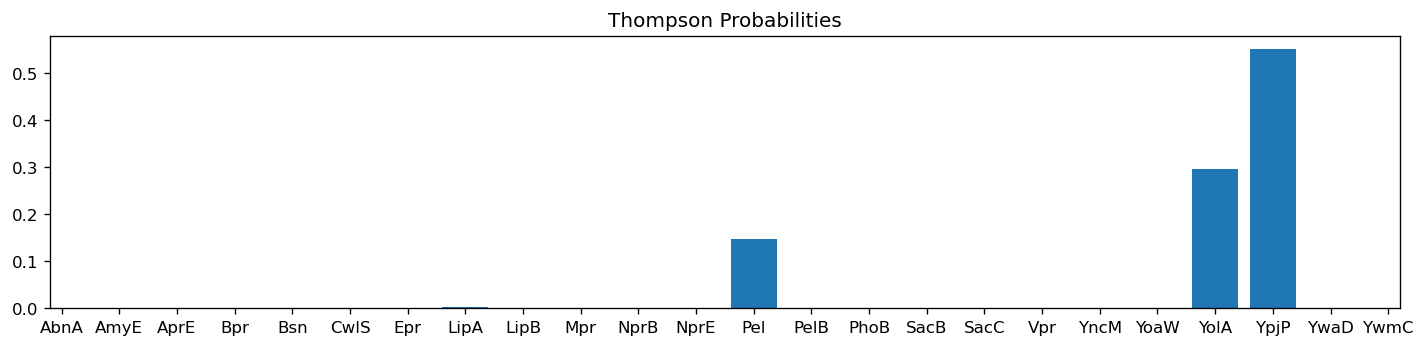

In [21]:
fig, ax = pyplot.subplots(figsize=(12,3), dpi=120)
ax.bar(x=numpy.arange(len(probs)), height=probs,)
ax.set(
    xticks=numpy.arange(len(probs)), 
    xticklabels=numpy.unique(df_inputs.strain.values),
    xlim=(-0.2,23.2),
)
ax.set_title("Thompson Probabilities")
pyplot.tight_layout()

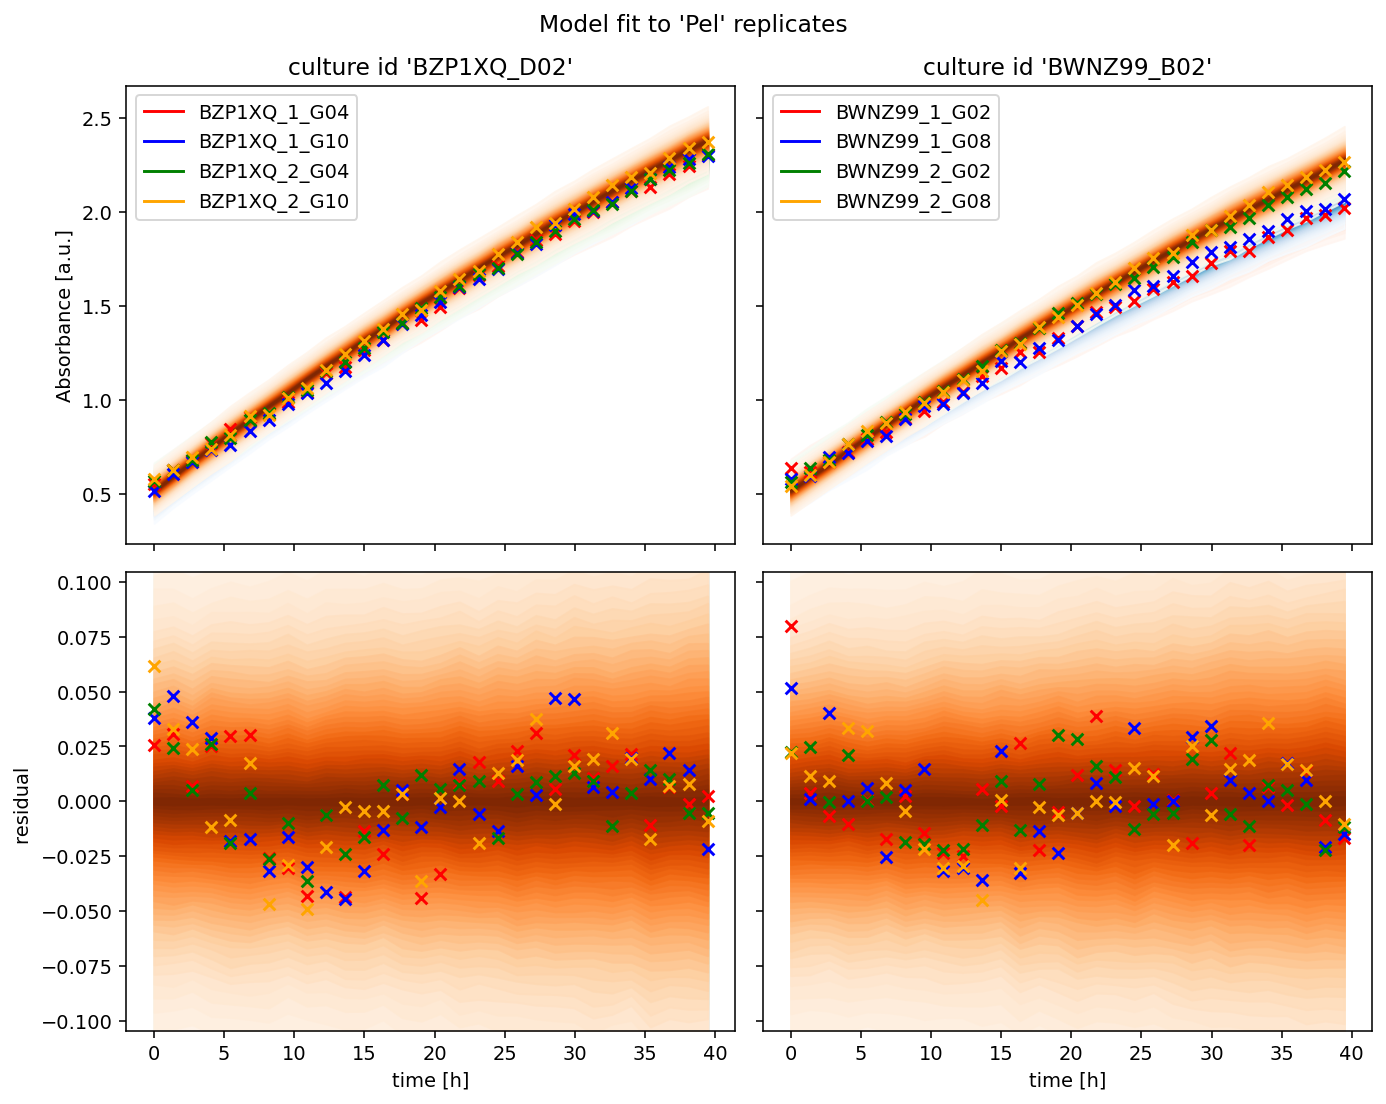

In [73]:
#for strain in posterior.strains.values:
strain="Pel"
culture_ids = df_inputs[df_inputs.strain==strain].index.to_list()
fig, axs = pyplot.subplots(
        dpi=140,
        figsize=(10, 4*len(culture_ids)),
        nrows=len(culture_ids),
        ncols=2,
        sharey="row",
        sharex="col",
        squeeze=False,
    )
for c, cid in enumerate(culture_ids):
    df = df_kinetics[df_kinetics.culture_id==cid]
    kinetic_ids = df.index
    residual_ptp = 0
    for r, (kid, (color, cmap)) in enumerate(zip(kinetic_ids, [
        ("red", "Reds"),
        ("blue", "Blues"),
        ("green", "Greens"),
        ("orange", "Oranges"),
    ])):


        # and the actual absorbance
        absorbance = idata.constant_data.cutinase_absorbance.sel(kinetic_id=kid)
        #print(color, kid, cid)
        
        axs[0,c].scatter(
            idata.constant_data.cutinase_time.values[0,:],
            absorbance,
            marker="x",
            color=color,
            zorder=10
        )
        theta = [
            posterior.absorbance_intercept.sel(kinetic_id=kid).values
        ] + list(cm_nitrophenol.theta_fitted[1:])
        loc, scale, df = cm_nitrophenol.predict_dependent(
            posterior.product_concentration.sel(kinetic_id=kid).values,
            theta=theta
            
        )
        pp_samples = scipy.stats.t.rvs(loc=loc, scale=scale, df=df)

        pymc3.gp.util.plot_gp_dist(
            ax=axs[0,c],
            samples=pp_samples.T,
            x=idata.constant_data.cutinase_time.values[0,:],
            palette=cmap,
            plot_samples=False,
        )
        
        #residuals
        median = numpy.median(pp_samples, axis=1)
        residuals = absorbance.values - median
        residual_ptp = max(residual_ptp, numpy.ptp(residuals))

        pymc3.gp.util.plot_gp_dist(
            ax=axs[1, c],
            samples=(pp_samples - median[:,None]).T,
            x=idata.constant_data.cutinase_time.values[0,:],
            plot_samples=False,
            palette=cmap
        )
        axs[1, c].scatter(
            idata.constant_data.cutinase_time.values[0,:], residuals, marker="x", color=color, zorder=10
        )
        axs[0, c].plot([], [], color=color, label=kid)
    # formatting
    axs[0, c].set_title(f"culture id '{cid}'")
    axs[1, c].set_xlabel("time [h]") 
    axs[0, c].legend()

axs[0, 0].set_ylabel(
    "Absorbance [a.u.]"
)
axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
axs[1, 0].set_ylabel("residual ")
fig.suptitle(
    f"Model fit to '{strain}' replicates"
)
fig.tight_layout()